In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
from pandas_datareader import data as pdr
import yfinance as yf
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Fragestellung
Wir betrachten den Aktienverlauf von Amazon und möchte folgende Frage mit einer Monte-Carlo-Simulation beantworten:<br />
Wie wird der Erwartungswert und die Standardabweichung (Volatilität) in einem Jahr aussehen, ausgehend vom 01.01.2022.

# Systemdefinition
Wir holen uns den Aktienverlauf eines Jahres von yahoo mit einer Python Bibliothek.<br />
Wir beschränken uns auf die Spalte "Adj Close" die den Wert der Aktie bei Handelsabschluss angibt.<br />

# Lösungsstrategie und Wahrscheinlichkeitsmodell
1) Die Spalte "Adj Close" (Aktie bei Handelsschluss) wird analysiert, d.h. <br />
die prozentuale Veränderung von einem Tag zum nächsten. Aus dieser Analyse folgt <br />
die Verteilung $N(\mu,\sigma)$ mit den dazugehörigen **Schätzern** $\overline{x}$ und $s$.<br />
2) Mit einem **Anpassungstest** wird geprüft ob die prozentualen Veränderungen einer Normalverteilungen folgen.<br />
Die Überprüfung erfolgt mit dem Kolmogorov-Smirnov Test, welcher folgende Hypothesen aufstellt: <br />
$$ H_0: \textit{ Zwei Proben stammen aus der selben Verteilung} $$
$$ H_1: \textit{ Zwei Proben stammen aus verschiedenen Verteilungen} $$
Der Kolmogorov-Smirnov Test quantifiziert eine Distanz zwischen der Empirical Cumulative Distribution Function (ECDF) von den Samples und der referenzierten Cumulative Distribution Function (CDF).<br /><br />
$$D_n = \sup_{x}|F_n(x) – F(x)|$$
$sup_x$ steht für den Supremum aus einer Menge an Distanzen. Das heisst, die Statistik nimmt sich die grösste absolute Differenz zwischen zwei Verteilungen, entlang allen x Werten.<br />
Scipy bietet die Methode scipy.stats.kstest an, welche die KS-Statistik und den p-Value zurück gibt. Gewählt wird eine Irrtumswahrscheinlichkeit $0.05$ und das Konfidenzintervall beträgt somit $0.95$.<br />
Der Schwellenwert $p$ ist somit $0.05$. Das bedeutet falls $p < 0.05$ verwerfen wir $H_0$ da der berechnete p-Wert ausserhalb unserer Grenze liegt und zwei Proben nicht aus der selben Verteilung stammen.

Die ECDF (Empirical Cumulative Distribution Function) ist definiert als:<br /><br />
$$F_n(x) = P_n(X \leq x) = \frac{1}{n} \sum^{n}_{i=1}I(X_i \leq x)$$
Die CDF (Cumulative Distribution Function) ist definiert als:<br /><br />
$$F(x)=\Phi \left({\frac {x-\mu }{\sigma }}\right)={\frac {1}{2}}\left[1+\operatorname {erf} \left({\frac {x-\mu }{\sigma {\sqrt {2}}}}\right)\right]$$
Der Gauss Fehler oder Error Function ist definiert als:<br /><br />
$$\operatorname {erf} z={\frac {2}{\sqrt {\pi }}}\int _{0}^{z}e^{-t^{2}}\,\mathrm {d} t$$
3) Die Simulation wird sich zufällige Werte dieser Verteilung $N(\mu,\sigma)$ herausgreifen<br />
und so erhalten wir eine **Zufallsvariable** $S$. Diese **Zufallsvariable** $S$ wird unser Störfaktor genannt,<br />
mit welchem wir den nächsten Tag berechnen werden. Folgende Gleichung verdeutlicht das Geschriebene:<br />
$$  p_{t+1} = p_{t} * (1 + S) $$
$$ S \sim N(\mu, \sigma) $$
$$ S := Störfaktor \space (Zufallsvariable) $$
Die Berechnung $  p_{t+1} = p_{t} * (1 + S) $ des Preises für alle Folgetage kann als **homogene Markov-Kette** angesehen werden.<br />
Die Wahrscheinlichkeit für die Zufallsvariable $S \sim N(\mu, \sigma)$ ist für jeden Durchlauf im Algorithmus eine andere.<br />
Wir wählen für die Anzahl der zu prognostizierenden Tage $n=252$.<br />
Für die Anzahl der Simulationen $n_{sim}=10'000$

# Ergebnis
Aus dem Anpassungstest sehen wir, dass die prozentualen Veränderungen des Aktienkurses einer Normalverteilung mit $N(\mu, \sigma)$ folgt.<br />
Wir wählen für den Punktschätzer $\sigma=0.032$.<br />
Aus 10'000 Simulationen mit jeweils 252 Tagen erhalten wir dieselbe Standardabweichung (minimale Abweichung) und somit unsere gesuchte Volatilität $\hat{\sigma}=0.032$.<br />
Der Erwartungswert bleibt mit $-0.002$ unverändert, weil wir aus einer Normalverteilung mit demselben Erwartungswert unsere Zufallsvariablen gezogen haben.

## Analyse

In [125]:
start = datetime(2022, 1, 1)
end = datetime.today()
yf.pdr_override()
df = yf.download("AMZN", start, end)

[*********************100%***********************]  1 of 1 completed


In [126]:
changes = df["Adj Close"].pct_change()
sigma = changes.std()
mu = changes.mean()

In [127]:
# remove nan with 0 for changes
changes = changes.fillna(0)

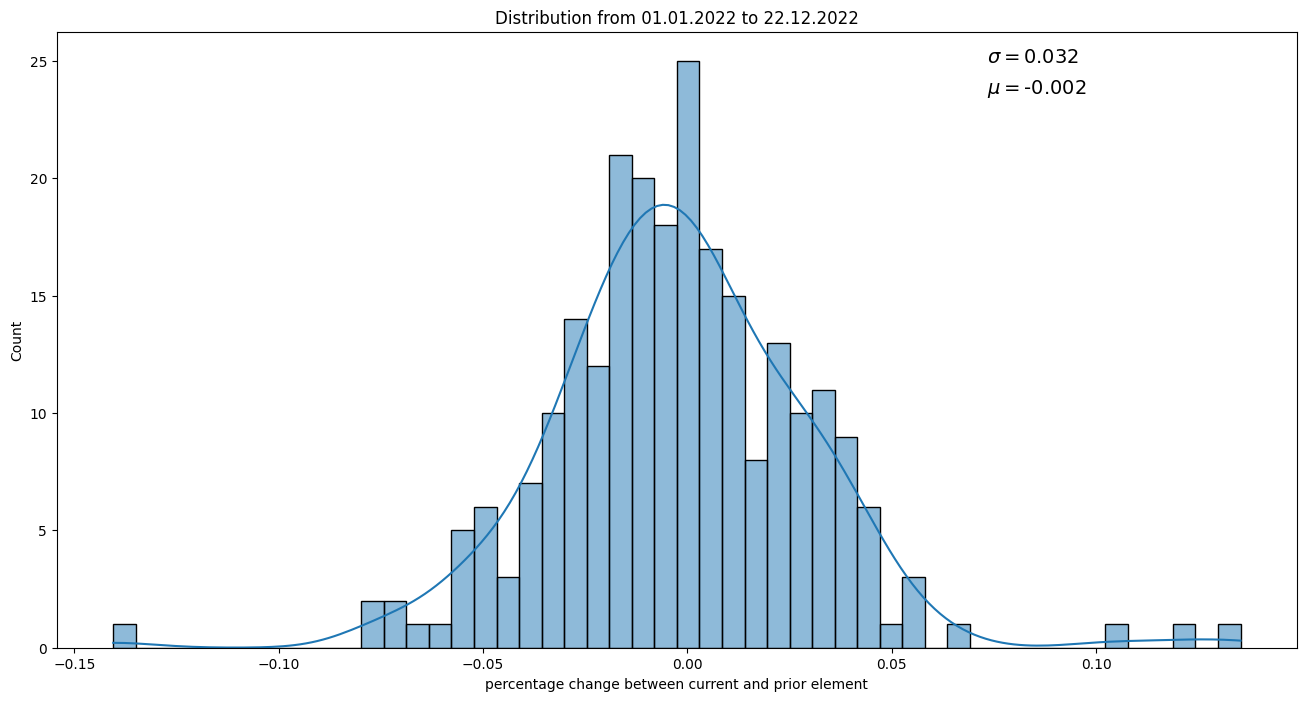

In [128]:
plt.figure(figsize=(16, 8))
plt.title("Distribution from 01.01.2022 to 22.12.2022")
plt.text(0.75, 0.95, r"$\sigma =$" + str(np.round(sigma, 3)), fontsize=14, transform=plt.gca().transAxes)
plt.text(0.75, 0.90, r"$\mu =$" + str(np.round(mu, 3)), fontsize=14, transform=plt.gca().transAxes)
plt.xlabel("percentage change between current and prior element")
sns.histplot(changes, kde=True, bins=50)
plt.show()

## Anpassungstest

In [129]:
from scipy.stats import kstest, shapiro
from scipy.stats import norm
import scipy.stats as st
np.set_printoptions(suppress=True)

In [130]:
result = kstest(changes, "norm", (mu, sigma))

In [131]:
print("K-S statistic: {}\np-value: {}".format(result[0], result[1]))

K-S statistic: 0.049052390777688415
p-value: 0.5800378565315749


Wir lehnen $H_0$ nicht ab da $p > 0.05$:<br />
$$ H_0: \textit{ Zwei Proben stammen aus der selben Verteilung} $$
und nutzen zufällige Werte einer Normalverteilung für unsere Zufallsvariable.

## Simulation

In [132]:
last_price = df["Adj Close"][-1]
n_simulations = 10000
n_days = 252
prices = []
simulation_df = pd.DataFrame()

for n_sim in range(n_simulations):
    prices.clear()
    price = last_price * (1 + np.random.normal(mu, sigma))
    prices.append(price)
    for n_day in range(n_days):
        price = prices[n_day] * (1 + np.random.normal(mu, sigma))
        prices.append(price)
    simulation_df[n_sim] = prices

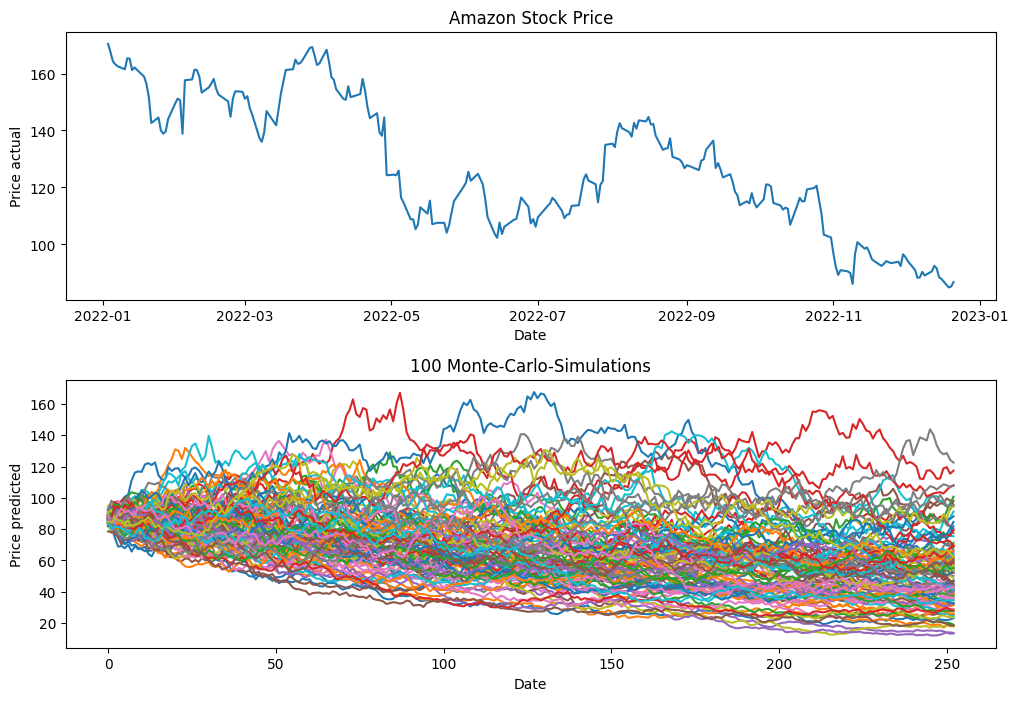

In [133]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
ax1.plot(df["Adj Close"])
ax1.set_title("Amazon Stock Price")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price actual")
ax2.plot(simulation_df.iloc[:, :100])
ax2.set_title("100 Monte-Carlo-Simulations")
ax2.set_xlabel("Date")
ax2.set_ylabel("Price predicted")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.show()

In [134]:
# create new df to plot previous price concated with simulated price
simulation_df.index = pd.date_range(start=end, periods=n_days + 1)
sim = pd.concat([df, simulation_df[0]], axis=1)
sim = sim.rename(columns={0: "Simulated"})

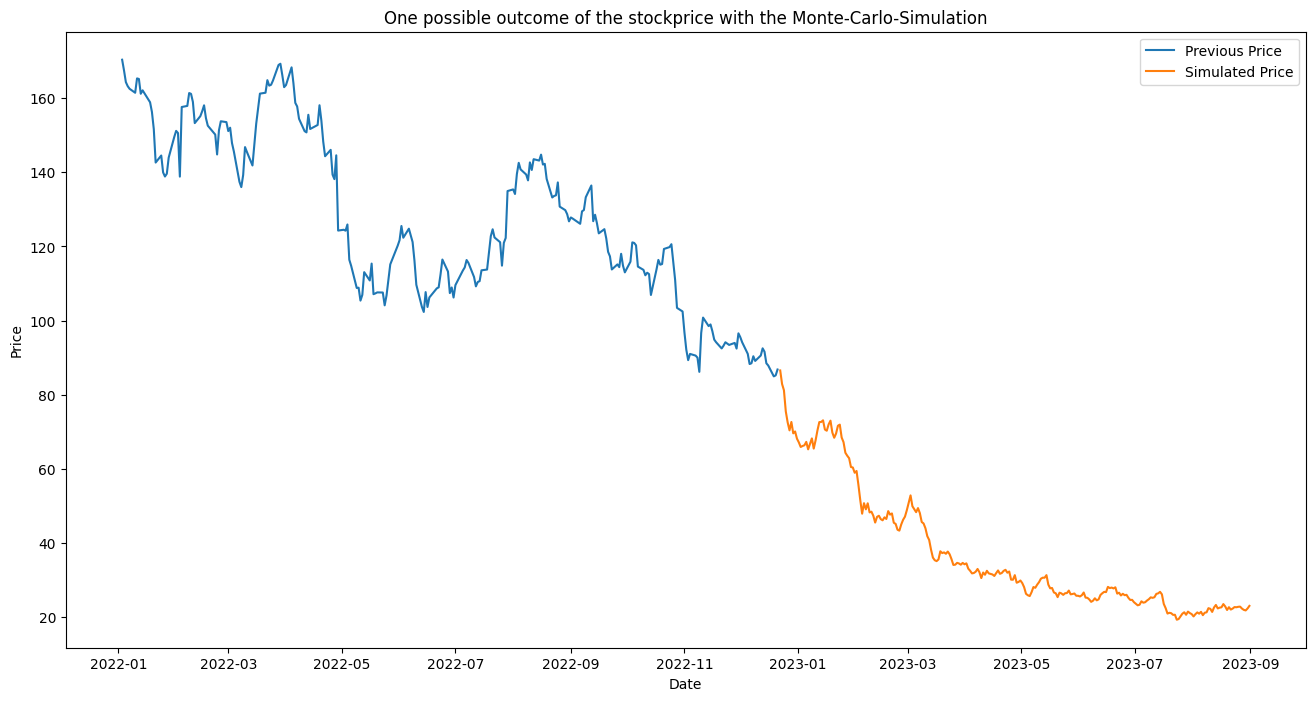

In [135]:
plt.figure(figsize=(16, 8))
plt.plot(sim[["Adj Close", "Simulated"]])
plt.title("One possible outcome of the stockprice with the Monte-Carlo-Simulation")
plt.legend(["Previous Price", "Simulated Price"])
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

### Berechnung der Volatilität aller Simulationen

In [136]:
sim_sigmas = []
sim_mus = []
for sim in range(10_000):
    sim_changes = simulation_df[sim].pct_change()
    sim_sigma = sim_changes.std()
    sim_mu = sim_changes.mean()
    sim_sigmas.append(sim_sigma)
    sim_mus.append(sim_mu)
n = len(sim_sigmas)
sigma_hat = sum(sim_sigmas) / n
mu_hat = sum(sim_mus) / n

In [137]:
print("sigma_hat= {}\nsigma= {}\nmu_hat= {}\nmu= {}".format(
    sigma_hat,
    sigma,
    mu_hat,
    mu
))

sigma_hat= 0.03174153377112426
sigma= 0.031758518203968564
mu_hat= -0.0022524743111244977
mu= -0.002260063043043584


# Ignorieren

In [138]:
data_normal = np.random.normal(np.mean(changes), np.std(changes), len(changes))

In [139]:
values, base = np.histogram(changes)
values_norm, base_norm = np.histogram(data_normal)

In [140]:
cumulative = np.cumsum(values)
cumulative_normal = np.cumsum(values_norm)

In [141]:
# plt.plot(base[:-1], cumulative, c="blue")
# plt.plot(base_norm[:-1], cumulative_normal, c="green")

In [142]:
# sns.ecdfplot(changes, c='blue')

In [143]:
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [144]:
# get_best_distribution(changes)